# 1. SVD - Image Compression

In [17]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [21]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy import linalg as LA

m, n = 2, 3
A = np.random.rand(m,n)

U, S, V = LA.svd(A)

#checking if U, V are arthogonal and S is a diagonal matrix with nonnegative decreasing elements
print('Frobenius norm of (UU^T - I) = ', LA.norm(U.dot(U.T) - np.eye(m)))
print('\nS = ', S, '\n')
print('Frobenius norm of (VV^T - I) = ', LA.norm(V.dot(V.T) - np.eye(n)))

Frobenius norm of (UU^T - I) =  5.005305619137078e-16

S =  [1.30099327 0.74575179] 

Frobenius norm of (VV^T - I) =  4.006325527053343e-16


## Image Compression

In [22]:
import matplotlib.image as mping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

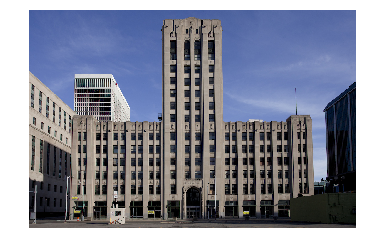

In [23]:
img = mping.imread('./data/building2.jpg')
plt.imshow(img)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

gray.shape =  (960, 1440)


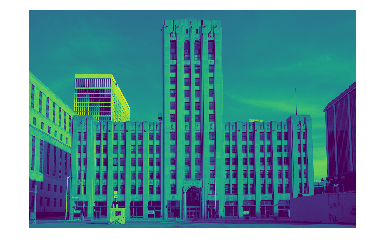

In [38]:
# to gray
gray = 0.2125 * img[:, :, 0] + 0.7154 *img[:, :, 1] + 0.0721 * img[:, :, 2]
print('gray.shape = ', gray.shape)
plt.imshow(gray)
plt.axis('off')
plt.show()

In [39]:
from numpy import linalg as LA

U, S, V = LA.svd(gray)

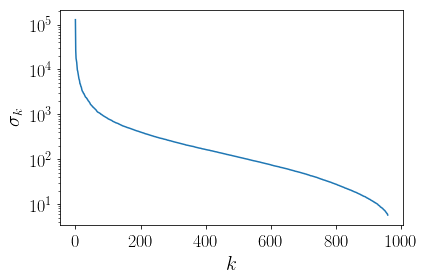

In [40]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('./data/singular_value.pdf') as pdf:
    plt.semilogy(S)
    plt.xlabel('$k$', fontsize = 20)
    plt.ylabel('$\sigma_k$', fontsize = 20)
    # We change the fontsize of minor ticks label
    plt.tick_params(axis='both', labelsize=18)
    plt.tight_layout()
    pdf.savefig()
    plt.show()

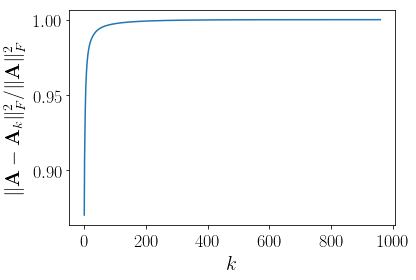

In [45]:
# percentage of preserving energy

with PdfPages('./data/energy_preserved.pdf') as pdf:
    a = np.sum(S**2)
    b = np.zeros_like(S)
    for i in range(S.shape[0]):
        b[i] = np.sum(S[:i+1]**2, axis = 0)/a
    
    plt.plot(b)
    plt.xlabel('$k$', fontsize = 20)
    plt.ylabel('$\|\mathbf{A} - \mathbf{A}_k\|_F^2 / \|\mathbf{A}\|_F^2$', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tight_layout()
    pdf.savefig()
    plt.show()

In [46]:
## error
e =  1- b

In [47]:
def approx_rank_k(U, S, V, k):
    Uk = U[:, :k]
    Sk = S[:k]
    Vk = V[:k, :]
    return np.around(Uk.dot(np.diag(Sk)).dot(Vk))

# A = gray
# U, S, V = LA.svd(A)
A1 = []
for k in range(5, 100, 5):
    A1.append(approx_rank_k(U, S, V,k))

MovieWriter imagemagick unavailable.


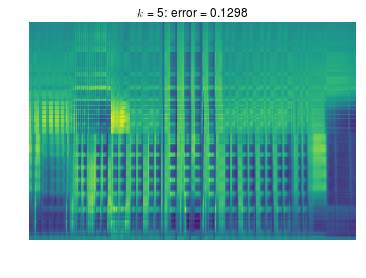

In [48]:
# show results
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation 
fig, ax = plt.subplots()
def update(i):
    ani = plt.cla()
    ani = plt.imshow(A1[i])
    label = '$k$ = %d: error = %.4f' %(5*i + 5, e[i])
    ax.set_xlabel(label)
    ani = plt.axis('off')
    ani = plt.title(label)

    return ani, ax 

anim = FuncAnimation(fig, update, frames=np.arange(0, len(A1)), interval=500)
anim.save('./data/a.gif', dpi = 300, writer = 'imagemagick')
plt.show()

# 2. SVD for Recommendation System

In [49]:
import pandas as pd 
import numpy as np
from numpy import linalg as LA
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 

class SVD_RS(object):
    """docstring for CF"""
    def __init__(self, Y_data, K, user_based = 1):
        self.Y_data = Y_data
        self.K = K
        self.user_based = user_based
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(Y_data[:, 0])) + 1 
        self.n_items = int(np.max(Y_data[:, 1])) + 1            
        #self.all_users = self.Y_data[:,0] # all users (may be duplicated)
        self.n_ratings = Y_data.shape[0]
        # normalized data
        self.Ybar_data = self.Y_data.copy().astype(np.float32)

    def normalize_Y(self):
        if self.user_based:
            user_col = 0
            item_col = 1
            n_objects = self.n_users

        # if we want to normalize based on item, just switch first two columns of data
        else: # item bas
            user_col = 1
            item_col = 0 
            n_objects = self.n_items

        users = self.Y_data[:, user_col] 
        self.mu = np.zeros((n_objects,))
        for n in range(n_objects):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2].astype(np.float32)
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]
            #print self.Ybar_data

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.todense()


    
    def fit(self): 
        """
        matrix factorization using SVD
        """
        self.normalize_Y()
        U, S, V = LA.svd(self.Ybar)
        Uk = U[:, :self.K]
        Sk = S[:self.K]
        Vkt = V[:self.K, :]
        self.res = Uk.dot(np.diag(Sk)).dot(Vkt)
        
    def pred(self, u, i):
        """ 
        predict the rating of user u for item i 
        if you need the un
        """
        u = int(u)
        i = int(i)
        
        if self.user_based:
            bias = self.mu[u]
        else: 
            bias = self.mu[i]
        pred = self.res[i, u] + bias 
        if pred < 1:
            return 1 
        if pred > 5: 
            return 5 
        return pred 
        
    
    def pred_for_user(self, user_id):
        ids = np.where(self.Y_data_n[:, 0] == user_id)[0]
        items_rated_by_u = self.Y_data_n[ids, 1].tolist()              
        
        y_pred = self.X.dot(self.W[:, user_id]) + self.mu[user_id]
        predicted_ratings= []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                predicted_ratings.append((i, y_pred[i]))
        
        return predicted_ratings
    
    def evaluate_RMSE(self, rate_test):
        n_tests = rate_test.shape[0]
        SE = 0 # squared error
        for n in range(n_tests):
            pred = self.pred(rate_test[n, 0], rate_test[n, 1])
            SE += (pred - rate_test[n, 2])**2 

        RMSE = np.sqrt(SE/n_tests)
        return RMSE

## Áp dụng lên MovieLens 100k

In [50]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('./data/ml-100k/ub.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('./data/ml-100k/ub.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.as_matrix()
rate_test = ratings_test.as_matrix()

# indices start from 0
rate_train[:, :2] -= 1
rate_test[:, :2] -= 1

In [51]:
rs = SVD_RS(rate_train, K = 10, user_based = 1)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('\nUser-based MF, RMSE =', RMSE)


User-based MF, RMSE = 1.0185374536760587


In [52]:
rs = SVD_RS(rate_train, K = 10, user_based = 0)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('\nItem-based MF, RMSE =', RMSE)


Item-based MF, RMSE = 1.0148652433564627


## MovieLens 1M

In [54]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', names=r_cols, encoding='latin-1')
ratings = ratings_base.as_matrix()
ratings[:, :2] -= 1

In [55]:
from sklearn.model_selection import train_test_split

rate_train, rate_test = train_test_split(ratings, test_size=0.33, random_state=42)
# print X_train.shape, X_test.shape

rs = SVD_RS(rate_train, K = 2, user_based = 0)
rs.fit()
# evaluate on test data
RMSE = rs.evaluate_RMSE(rate_test)
print('\nItem-based MF, RMSE =', RMSE)


Item-based MF, RMSE = 0.953848588308199
